In [1]:
import os
import cv2 
import etl.modules.equi2perspec as E2P 
import matplotlib.pyplot as plt

In [2]:
equ = E2P.Equirectangular('data/images/__7RwCSRHYUHVB9kOP1sXQ.jpeg')    # Load equirectangular image

#
# FOV unit is degree 
# theta is z-axis angle(right direction is positive, left direction is negative)
# phi is y-axis angle(up direction positive, down direction negative)
# height and width is output image dimension 
#
# img = equ.GetPerspective(60, 0, 0, 720, 1440) # Specify parameters(FOV, theta, phi, height, width)

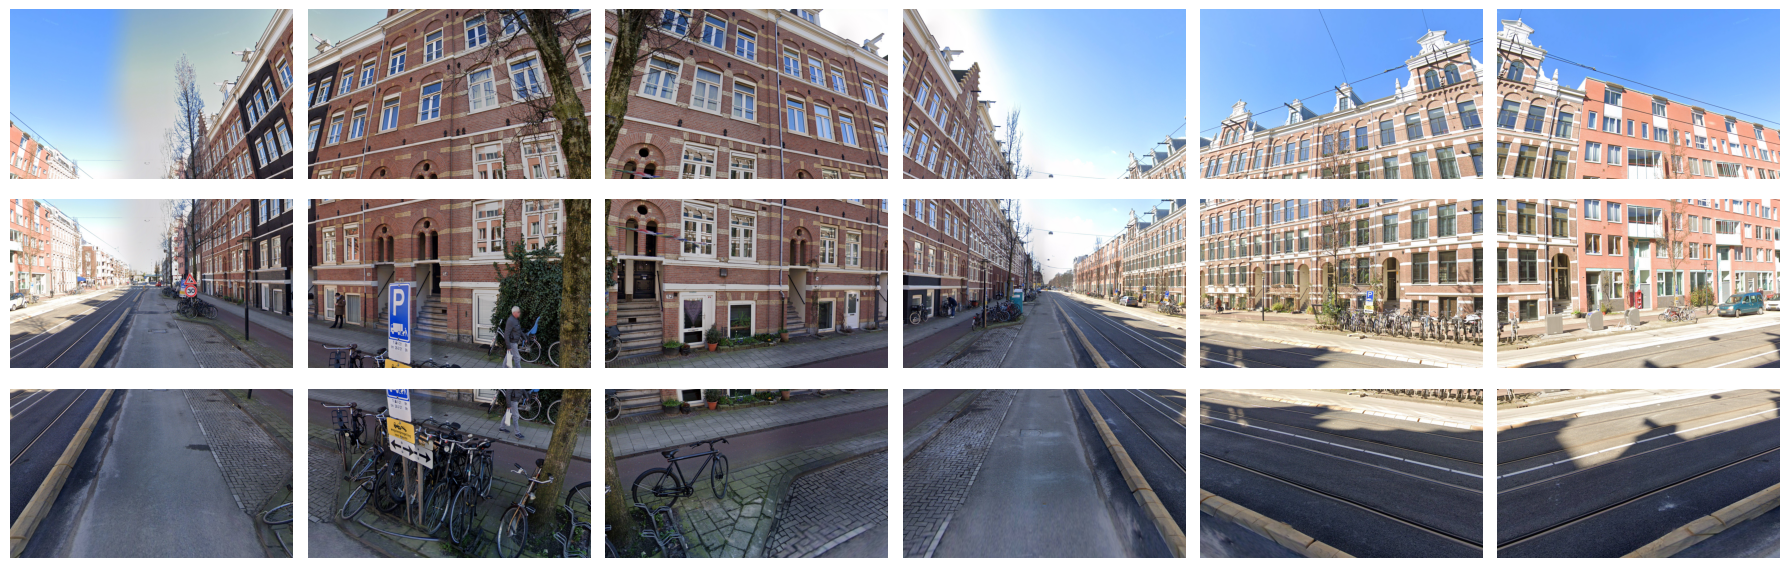

In [3]:
# Set the number of images (6 images from 0 to 360 degrees in steps of 60)
fig, axes = plt.subplots(3, 6, figsize=(18, 6))  # 1 row, 6 columns

for idx, i in enumerate(range(0, 360, 60)):
    for jdx, j in enumerate(range(30, -60, -30)):
        # Get the perspective image for the given theta and phi angles
        img = equ.GetPerspective(60, i, j, 1080, 1800)  # Specify parameters(FOV, theta, phi, height, width)

        # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image on the subplot at the appropriate (row, col) position
        axes[jdx, idx].imshow(image_rgb)
        axes[jdx, idx].axis('off')  # Hide the axes for each image

# Show the figure with all images side by side
plt.tight_layout()
plt.show()

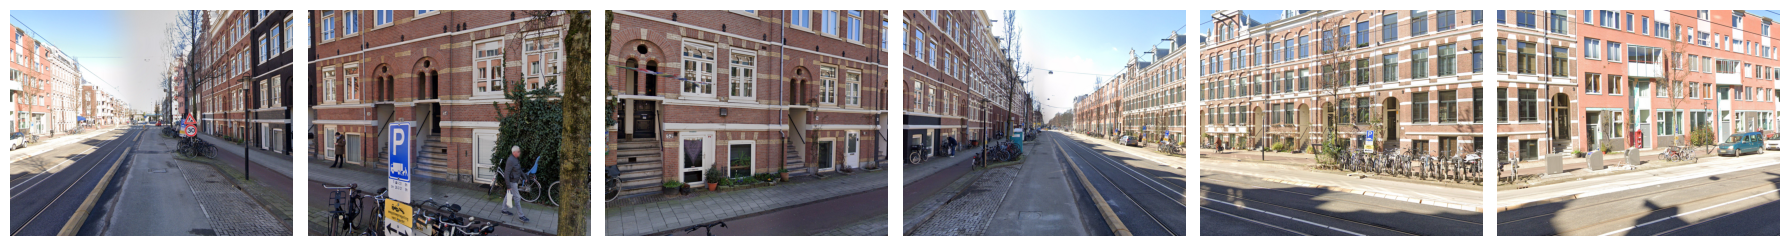

In [4]:
# Set the number of images (6 images from 0 to 360 degrees in steps of 60)
fig, axes = plt.subplots(1, 6, figsize=(18, 9))  # 1 row, 6 columns

for idx, i in enumerate(range(0, 360, 60)):
    # Get the perspective image for the given theta angle
    img = equ.GetPerspective(60, i, 0, 1440, 1800)  # Specify parameters(FOV, theta, phi, height, width)

    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image on the subplot
    axes[idx].imshow(image_rgb)
    axes[idx].axis('off')  # Hide the axes for each image

# Show the figure with all images side by side
plt.tight_layout()
plt.show()

In [14]:
def graythresh(array,level):
    '''array: is the numpy array waiting for processing
    return thresh: is the result got by OTSU algorithm
    if the threshold is less than level, then set the level as the threshold
    by Xiaojiang Li
    '''
    
    import numpy as np
    
    maxVal = np.max(array)
    minVal = np.min(array)
    
#   if the inputImage is a float of double dataset then we transform the data 
#   in to byte and range from [0 255]
    if maxVal <= 1:
        array = array*255
        # print "New max value is %s" %(np.max(array))
    elif maxVal >= 256:
        array = np.int((array - minVal)/(maxVal - minVal))
        # print "New min value is %s" %(np.min(array))
    
    # turn the negative to natural number
    negIdx = np.where(array < 0)
    array[negIdx] = 0
    
    # calculate the hist of 'array'
    dims = np.shape(array)
    hist = np.histogram(array,range(257))
    P_hist = hist[0]*1.0/np.sum(hist[0])
    
    omega = P_hist.cumsum()
    
    temp = np.arange(256)
    mu = P_hist*(temp+1)
    mu = mu.cumsum()
    
    n = len(mu)
    mu_t = mu[n-1]
    
    sigma_b_squared = (mu_t*omega - mu)**2/(omega*(1-omega))
    
    # try to found if all sigma_b squrered are NaN or Infinity
    indInf = np.where(sigma_b_squared == np.inf)
    
    CIN = 0
    if len(indInf[0])>0:
        CIN = len(indInf[0])
    
    maxval = np.max(sigma_b_squared)
    
    IsAllInf = CIN == 256
    if IsAllInf !=1:
        index = np.where(sigma_b_squared==maxval)
        idx = np.mean(index)
        threshold = (idx - 1)/255.0
    else:
        threshold = level
    
    if np.isnan(threshold):
        threshold = level
    
    return threshold

def VegetationClassification(Img):
    '''
    This function is used to classify the green vegetation from GSV image,
    This is based on object based and otsu automatically thresholding method
    The season of GSV images were also considered in this function
        Img: the numpy array image, eg. Img = np.array(Image.open(StringIO(response.content)))
        return the percentage of the green vegetation pixels in the GSV image
    
    By Xiaojiang Li
    '''
    
    import pymeanshift as pms
    import numpy as np
    
    # use the meanshift segmentation algorithm to segment the original GSV image
    (segmented_image, labels_image, number_regions) = pms.segment(Img,spatial_radius=6,
                                                     range_radius=7, min_density=40)
    
    I = segmented_image/255.0
    
    red = I[:,:,0]
    green = I[:,:,1]
    blue = I[:,:,2]
    
    # calculate the difference between green band with other two bands
    green_red_Diff = green - red
    green_blue_Diff = green - blue
    
    ExG = green_red_Diff + green_blue_Diff
    diffImg = green_red_Diff*green_blue_Diff
    
    redThreImgU = red < 0.6
    greenThreImgU = green < 0.9
    blueThreImgU = blue < 0.6
    
    shadowRedU = red < 0.3
    shadowGreenU = green < 0.3
    shadowBlueU = blue < 0.3
    del red, blue, green, I
    
    greenImg1 = redThreImgU * blueThreImgU*greenThreImgU
    greenImgShadow1 = shadowRedU*shadowGreenU*shadowBlueU
    del redThreImgU, greenThreImgU, blueThreImgU
    del shadowRedU, shadowGreenU, shadowBlueU
    
    greenImg3 = diffImg > 0.0
    greenImg4 = green_red_Diff > 0
    threshold = graythresh(ExG, 0.1)
    
    if threshold > 0.1:
        threshold = 0.1
    elif threshold < 0.05:
        threshold = 0.05
    
    greenImg2 = ExG > threshold
    greenImgShadow2 = ExG > 0.05
    greenImg = greenImg1*greenImg2 + greenImgShadow2*greenImgShadow1
    del ExG,green_blue_Diff,green_red_Diff
    del greenImgShadow1,greenImgShadow2
    
    # calculate the percentage of the green vegetation
    greenPxlNum = len(np.where(greenImg != 0)[0])
    greenPercent = greenPxlNum/(1440*1800)*100
    del greenImg1,greenImg2
    del greenImg3,greenImg4
    
    return greenImg, greenPercent

/var/folders/0y/xnx3sz6927z6fg600l0yk8p40000gn/T/ipykernel_4993/1484104950.py:40: RuntimeWarning: invalid value encountered in divide
  sigma_b_squared = (mu_t*omega - mu)**2/(omega*(1-omega))
/Users/khoadangnguyen/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/khoadangnguyen/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.45671296296296293
10.497878086419753
2.194868827160494
1.1909722222222223
5.842515432098765
3.3984953703703704


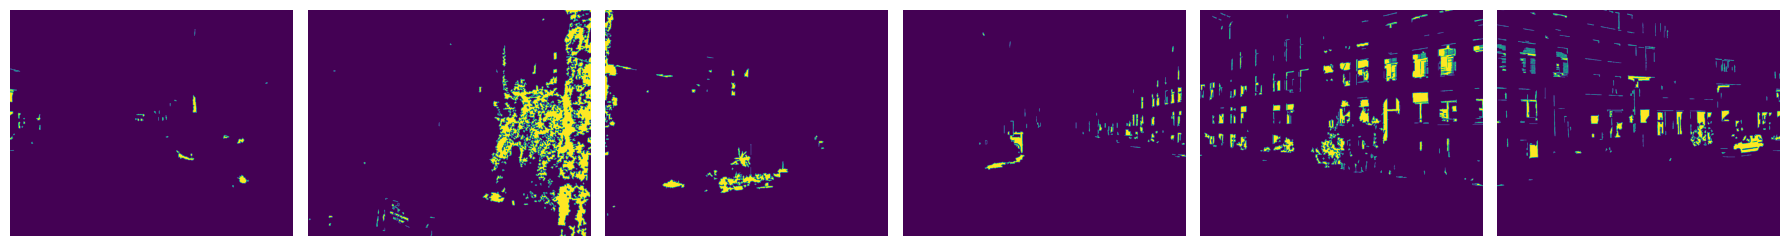

In [15]:
# Set the number of images (6 images from 0 to 360 degrees in steps of 60)
fig, axes = plt.subplots(1, 6, figsize=(18, 9))  # 1 row, 6 columns
green_percent_list = []

for idx, i in enumerate(range(0, 360, 60)):
    # Get the perspective image for the given theta angle
    img = equ.GetPerspective(60, i, 0, 1440, 1800)  # Specify parameters(FOV, theta, phi, height, width)

    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_green_only, green_percent = VegetationClassification(image_rgb)

    # Display the image on the subplot
    axes[idx].imshow(image_green_only)
    axes[idx].axis('off')  # Hide the axes for each image
    green_percent_list.append(green_percent)

# Show the figure with all images side by side
for percent in green_percent_list:
    print(percent)

plt.tight_layout()
plt.show()